# PCA

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.metrics import mean_squared_error, mean_absolute_error

In [17]:
train = pd.read_csv('../data/train.csv')
test = pd.read_csv('../data/test.csv')
rul = pd.read_csv('../data/rul.csv')

print(f"Train: {train.shape}, Test: {test.shape}, RUL: {rul.shape}")

Train: (20631, 18), Test: (13096, 17), RUL: (100, 1)


In [16]:
feature_cols = [
    'setting_1', 'setting_2', 'setting_3',
    'sensor_2', 'sensor_3', 'sensor_4', 'sensor_7', 
    'sensor_8', 'sensor_11', 'sensor_12', 'sensor_13', 
    'sensor_14', 'sensor_15', 'sensor_17', 'sensor_21'
]

print(f"Features: {len(feature_cols)}")

Features: 15


In [ ]:
healthy_threshold = 125
train_healthy = train[train['RUL'] > healthy_threshold][feature_cols]

print(f"Healthy samples: {len(train_healthy)} / {len(train)}")

Healthy samples: 8031 / 20631


We train PCA only on healthy engine data (RUL > 125 cycles) to learn what "normal" operation looks like. This way, when the model reconstructs data from degraded engines (RUL < 125), it struggles and produces high reconstruction error, which signals an anomaly. If we trained on all data including near-failure states, the model would consider degradation as normal and lose its ability to detect when engines are actually failing.

In [ ]:
n_components = 5
pca = PCA(n_components=n_components)
train_healthy_pca = pca.fit_transform(train_healthy)

print(f"Explained variance ratio: {pca.explained_variance_ratio_}")
print(f"Cumulative variance: {pca.explained_variance_ratio_.cumsum()[-1]:.3f}")

Explained variance ratio: [0.52927265 0.07291256 0.06363663 0.06119178 0.05286983]
Cumulative variance: 0.780


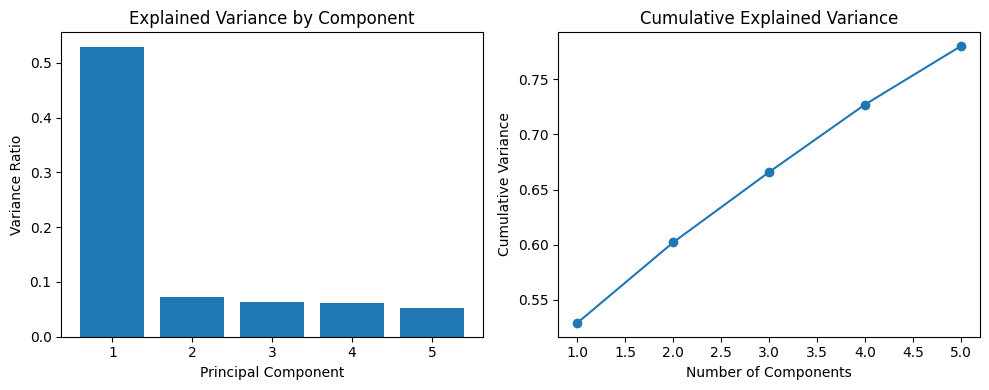

In [ ]:
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.bar(range(1, n_components+1), pca.explained_variance_ratio_)
plt.xlabel('Principal Component')
plt.ylabel('Variance Ratio')
plt.title('Explained Variance by Component')

plt.subplot(1, 2, 2)
plt.plot(range(1, n_components+1), pca.explained_variance_ratio_.cumsum(), marker='o')
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Variance')
plt.title('Cumulative Explained Variance')
plt.tight_layout()
plt.show()

In [ ]:
train_pca = pca.transform(train[feature_cols])
train_reconstructed = pca.inverse_transform(train_pca)
train['reconstruction_error'] = np.mean((train[feature_cols].values - train_reconstructed)**2, axis=1)

# Anomaly threshold (95th percentile)
threshold = train['reconstruction_error'].quantile(0.95)
print(f"Anomaly threshold (95%): {threshold:.4f}")

Anomaly threshold (95%): 0.6558


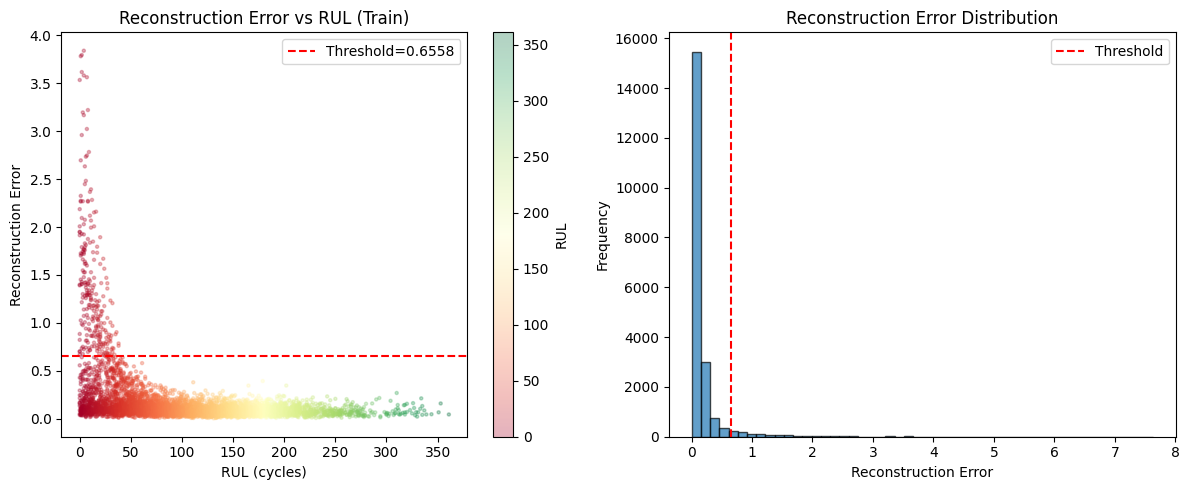

In [ ]:
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
sample = train.sample(min(5000, len(train)))
scatter = plt.scatter(sample['RUL'], sample['reconstruction_error'], 
                     c=sample['RUL'], cmap='RdYlGn', alpha=0.3, s=5)
plt.axhline(threshold, color='red', linestyle='--', label=f'Threshold={threshold:.4f}')
plt.xlabel('RUL (cycles)')
plt.ylabel('Reconstruction Error')
plt.title('Reconstruction Error vs RUL (Train)')
plt.legend()
plt.colorbar(scatter, label='RUL')

plt.subplot(1, 2, 2)
plt.hist(train['reconstruction_error'], bins=50, edgecolor='black', alpha=0.7)
plt.axvline(threshold, color='red', linestyle='--', label=f'Threshold')
plt.xlabel('Reconstruction Error')
plt.ylabel('Frequency')
plt.title('Reconstruction Error Distribution')
plt.legend()
plt.tight_layout()
plt.show()

In [ ]:
test_pca = pca.transform(test[feature_cols])
test_reconstructed = pca.inverse_transform(test_pca)
test['reconstruction_error'] = np.mean((test[feature_cols].values - test_reconstructed)**2, axis=1)

# Aggregate by engine (use last measurement)
predictions = []
for unit_id in test['unit_id'].unique():
    engine_data = test[test['unit_id'] == unit_id]
    
    # Features from last cycles
    last_error = engine_data.iloc[-1]['reconstruction_error']
    mean_error = engine_data['reconstruction_error'].mean()
    max_error = engine_data['reconstruction_error'].max()
    
    # Simple RUL mapping: higher error = lower RUL
    max_rul = 150
    degradation_factor = min(last_error / threshold, 1.0)
    predicted_rul = max_rul * (1 - degradation_factor)
    
    predictions.append({
        'unit_id': unit_id,
        'predicted_rul': predicted_rul,
        'last_error': last_error,
        'mean_error': mean_error,
        'max_error': max_error
    })

pred_df = pd.DataFrame(predictions)
pred_df['true_rul'] = rul['RUL'].values

In [ ]:
pred_df['error'] = pred_df['predicted_rul'] - pred_df['true_rul']
pred_df['abs_error'] = np.abs(pred_df['error'])

rmse = np.sqrt(mean_squared_error(pred_df['true_rul'], pred_df['predicted_rul']))
mae = mean_absolute_error(pred_df['true_rul'], pred_df['predicted_rul'])

# NASA score
def nasa_score(y_true, y_pred):
    diff = y_pred - y_true
    return np.sum(np.where(diff < 0, np.exp(-diff/13)-1, np.exp(diff/10)-1))

score = nasa_score(pred_df['true_rul'].values, pred_df['predicted_rul'].values)

print(f"RMSE: {rmse:.2f}")
print(f"MAE: {mae:.2f}")
print(f"NASA Score: {score:.2f}")
print(f"\nError mean: {pred_df['error'].mean():.2f}")
print(f"Error std: {pred_df['error'].std():.2f}")

RMSE: 55.11
MAE: 42.77
NASA Score: 1271544.43

Error mean: 40.35
Error std: 37.73


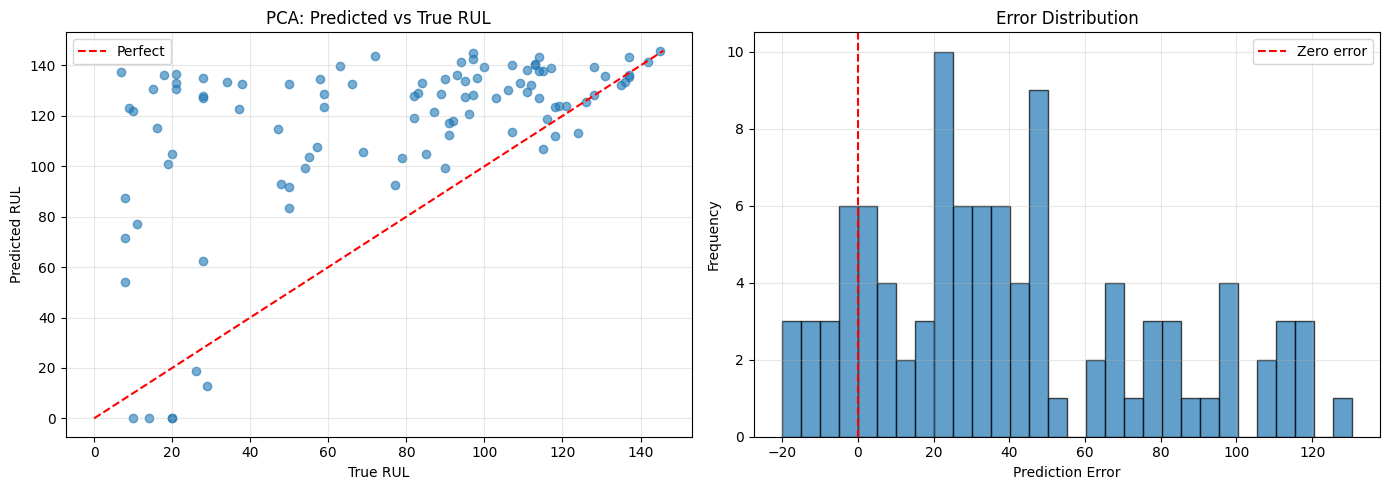

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Predicted vs True
axes[0].scatter(pred_df['true_rul'], pred_df['predicted_rul'], alpha=0.6)
min_rul = min(pred_df['true_rul'].min(), pred_df['predicted_rul'].min())
max_rul = max(pred_df['true_rul'].max(), pred_df['predicted_rul'].max())
axes[0].plot([min_rul, max_rul], [min_rul, max_rul], 'r--', label='Perfect')
axes[0].set_xlabel('True RUL')
axes[0].set_ylabel('Predicted RUL')
axes[0].set_title('PCA: Predicted vs True RUL')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Error distribution
axes[1].hist(pred_df['error'], bins=30, edgecolor='black', alpha=0.7)
axes[1].axvline(0, color='red', linestyle='--', label='Zero error')
axes[1].set_xlabel('Prediction Error')
axes[1].set_ylabel('Frequency')
axes[1].set_title('Error Distribution')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

In [15]:
pred_df.to_csv('../data/results/pca_predictions.csv', index=False)
print("✓ Results saved")

✓ Results saved
